In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/home/suriya/dcu/Group-Project


In [31]:
import numpy as np
import pandas as pd

In [91]:
from src.data import matrix, mitre

matrix_df = matrix()
mitre_df = mitre()

100%|██████████| 70/70 [00:00<00:00, 76.77it/s]


In [92]:
matrix_df

,Environment_1,Environment_2,TX,RX,Range,Angle,Bluetooth
0,large room,center open,iPhone XS,iPhone 8,1.523926,0.0,"[-84.0, -84.0, -71.0, -61.0, -83.0, -82.0, -82..."
1,large room,center open,iPhone XS,iPhone 8,1.219141,0.0,"[-59.0, -75.0, -75.0, -55.0, -55.0, -92.0, -75..."
2,large room,center open,iPhone XS,iPhone 8,3.047851,0.0,"[-82.0, -77.0, -78.0, -85.0, -85.0, -72.0, -75..."
3,large room,center open,iPhone XS,iPhone 8,4.571777,0.0,"[-71.0, -74.0, -69.0, -69.0, -64.0, -64.0, -76..."
4,large room,center open,iPhone XS,iPhone 8,2.438281,0.0,"[-79.0, -79.0, -73.0, -84.0, -74.0, -56.0, -56..."
...,...,...,...,...,...,...,...
102,large room,center open,iPhone XR,iPhone 11 Pro,2.438281,0.0,"[-55.0, -55.0, -79.0, -75.0, -73.0, -57.0, -57..."
103,large room,center open,iPhone XR,iPhone 11 Pro,3.657422,0.0,"[-76.0, -83.0, -63.0, -63.0, -71.0, -71.0, -91..."
104,large room,center open,iPhone XR,iPhone 11 Pro,1.523926,0.0,"[-72.0, -83.0, -54.0, -54.0, -55.0, -55.0, -75..."
105,large room,center open,iPhone XR,iPhone 11 Pro,4.571777,0.0,"[-71.0, -71.0, -93.0, -93.0, -68.0, -82.0, -62..."


In [93]:
from src.data import apply_fn_to_bluetooth

hyperparams = {
    "LinearApprox": {"TX": -61.02, "N": 2.187},
    "Friis": dict(Pt_dBm=0., Gt_dBi=1., Gr_dBi=1., f=2.4e9, L=1., n=2.),
    "LogNormal": dict(Pt_dBm=-20., Gt_dBi=1., Gr_dBi=1.,
                      f=2.4e9, d0=1., L=1., sigma=2., n=2)
}

In [94]:
mitre_ = pd.DataFrame(mitre_df.apply(apply_fn_to_bluetooth, axis=1, tunables=hyperparams).values.tolist())
matrix_ = pd.DataFrame(matrix_df.apply(apply_fn_to_bluetooth, axis=1, tunables=hyperparams).values.tolist())

In [39]:
from src.featutils import aggregate_features_from_folder
from src.features import radioprop

train_dir = "data/tc4tl_training_data_v1/tc4tl/data/train/"
train_key = pd.read_csv("data/tc4tl_training_data_v1/tc4tl/docs/tc4tl_train_key.tsv", sep="\t")
test_dir = "data/tc4tl_data_v5/tc4tl/data/test/"
test_key = pd.read_csv("data/tc4tl_test_key/tc4tl/docs/tc4tl_test_key.tsv", sep="\t")
dev_dir = "data/tc4tl_data_v5/tc4tl/data/dev/"
dev_key = pd.read_csv("data/tc4tl_data_v5/tc4tl/docs/tc4tl_dev_key.tsv", sep="\t")

trainset, pipe = aggregate_features_from_folder(train_dir, train_key, feat_fn=radioprop.extract_features,
                               postproc_fn=radioprop.postproc_feature_dicts, verbose=True, testing=0,
                               tunables=hyperparams)

Post-processing: zzzjbxhg_tc4tl20.csv: 100%|██████████| 15552/15552 [00:20<00:00, 752.58it/s]


In [65]:
feat_cols = [col for col in trainset.columns if col != 'DistanceFloat' ]
mitre_processed = pd.DataFrame(pipe.transform(mitre_)[:, :-1], columns=feat_cols)
mitre_processed['DistanceFloat'] = mitre_['DistanceFloat']
augset = pd.concat([trainset, mitre_processed]).reset_index(drop=True)

In [66]:
augset

,LinearApprox:Hist_0.15,LinearApprox:Hist_0.25,LinearApprox:Hist_0.35,LinearApprox:Hist_0.45,LinearApprox:Hist_0.55,LinearApprox:Hist_0.65,LinearApprox:Hist_0.75,LinearApprox:Hist_0.85,LinearApprox:Hist_0.95,LinearApprox:Hist_1.05,LinearApprox:Hist_1.15,LinearApprox:Hist_1.25,LinearApprox:Hist_1.35,LinearApprox:Hist_1.45,LinearApprox:Hist_1.55,LinearApprox:Hist_1.65,LinearApprox:Hist_1.75,LinearApprox:Hist_1.85,LinearApprox:Hist_1.95,LinearApprox:Hist_2.05,LinearApprox:Hist_2.15,LinearApprox:Hist_2.25,LinearApprox:Hist_2.35,LinearApprox:Hist_2.45,LinearApprox:Hist_2.55,LinearApprox:Hist_2.65,LinearApprox:Hist_2.75,LinearApprox:Hist_2.85,LinearApprox:Hist_2.95,LinearApprox:Hist_3.05,LinearApprox:Hist_3.15,LinearApprox:Hist_3.25,LinearApprox:Hist_3.35,LinearApprox:Hist_3.45,LinearApprox:Hist_3.55,LinearApprox:Hist_3.65,LinearApprox:Hist_3.75,LinearApprox:Hist_3.85,LinearApprox:Hist_3.95,LinearApprox:Hist_4.05,LinearApprox:Hist_4.15,LinearApprox:Hist_4.25,LinearApprox:Hist_4.35,LinearApprox:Hist_4.45,LinearApprox:Hist_4.55,LinearApprox:Hist_4.65,LinearApprox:Hist_4.75,LinearApprox:Hist_4.85,LinearApprox:Hist_4.95,Friis:Hist_0.15,Friis:Hist_0.25,Friis:Hist_0.35,Friis:Hist_0.45,Friis:Hist_0.55,Friis:Hist_0.65,Friis:Hist_0.75,Friis:Hist_0.85,Friis:Hist_0.95,Friis:Hist_1.05,Friis:Hist_1.15,Friis:Hist_1.25,Friis:Hist_1.35,Friis:Hist_1.45,Friis:Hist_1.55,Friis:Hist_1.65,Friis:Hist_1.75,Friis:Hist_1.85,Friis:Hist_1.95,Friis:Hist_2.05,Friis:Hist_2.15,Friis:Hist_2.25,Friis:Hist_2.35,Friis:Hist_2.45,Friis:Hist_2.55,Friis:Hist_2.65,Friis:Hist_2.75,Friis:Hist_2.85,Friis:Hist_2.95,Friis:Hist_3.05,Friis:Hist_3.15,Friis:Hist_3.25,Friis:Hist_3.35,Friis:Hist_3.45,Friis:Hist_3.55,Friis:Hist_3.65,Friis:Hist_3.75,Friis:Hist_3.85,Friis:Hist_3.95,Friis:Hist_4.05,Friis:Hist_4.15,Friis:Hist_4.25,Friis:Hist_4.35,Friis:Hist_4.45,Friis:Hist_4.55,Friis:Hist_4.65,Friis:Hist_4.75,Friis:Hist_4.85,Friis:Hist_4.95,LogNormal:Hist_0.15,LogNormal:Hist_0.25,LogNormal:Hist_0.35,LogNormal:Hist_0.45,LogNormal:Hist_0.55,LogNormal:Hist_0.65,LogNormal:Hist_0.75,LogNormal:Hist_0.85,LogNormal:Hist_0.95,LogNormal:Hist_1.05,LogNormal:Hist_1.15,LogNormal:Hist_1.25,LogNormal:Hist_1.35,LogNormal:Hist_1.45,LogNormal:Hist_1.55,LogNormal:Hist_1.65,LogNormal:Hist_1.75,LogNormal:Hist_1.85,LogNormal:Hist_1.95,LogNormal:Hist_2.05,LogNormal:Hist_2.15,LogNormal:Hist_2.25,LogNormal:Hist_2.35,LogNormal:Hist_2.45,LogNormal:Hist_2.55,LogNormal:Hist_2.65,LogNormal:Hist_2.75,LogNormal:Hist_2.85,LogNormal:Hist_2.95,LogNormal:Hist_3.05,LogNormal:Hist_3.15,LogNormal:Hist_3.25,LogNormal:Hist_3.35,LogNormal:Hist_3.45,LogNormal:Hist_3.55,LogNormal:Hist_3.65,LogNormal:Hist_3.75,LogNormal:Hist_3.85,LogNormal:Hist_3.95,LogNormal:Hist_4.05,LogNormal:Hist_4.15,LogNormal:Hist_4.25,LogNormal:Hist_4.35,LogNormal:Hist_4.45,LogNormal:Hist_4.55,LogNormal:Hist_4.65,LogNormal:Hist_4.75,LogNormal:Hist_4.85,LogNormal:Hist_4.95,CoarseGrain,DistanceFloat
0,0.000000,0.001520,0.168470,0.169364,0.075515,0.121704,0.161616,0.280702,0.179435,0.0,0.071315,0.129278,0.165803,0.0,0.185745,0.168889,0.0,0.120350,0.0,0.128736,0.0,0.0,0.063291,0.0,0.068376,0.0,0.0,0.072864,0.0,0.0,0.061571,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,0.156171,0.0,0.0,0.0,0.204698,0.0,0.0,0.0,0.0,0.027650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.003643,0.0,0.0,0.0,0.043011,0.0,0.0,0.0,0.0,0.138015,0.0,0.0,0.0,0.0,0.249545,0.0,0.000000,0.018195,0.218715,0.208955,0.092784,0.075515,0.121704,0.161616,0.0,0.303158,0.231047,0.0,0.179435,0.071315,0.0,0.129278,0.0,0.165803,0.0,0.0,0.185745,0.0,0.168889,0.0,0.0,0.0,0.120350,0.0,0.0,0.128736,0.0,0.0,0.0,0.063291,0.0,0.0,0.0,0.068376,0.0,0.0,0.0,0.0,0.072864,0.0,0.0,0.0,0.0,0.061571,0.0,1.800000
1,0.000000,0.009878,0.008501,0.014024,0.025172,0.020284,0.012121,0.007224,0.000000,0.0,0.000000,0.000000,0.008636,0.0,0.002160,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,

## Evaluate on augmented data

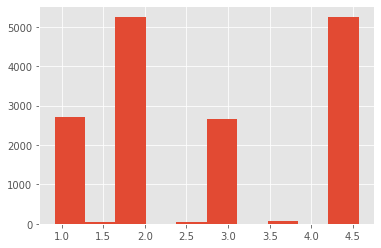

In [74]:
augset.DistanceFloat.hist();

In [77]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

X, y = augset[feat_cols], augset['DistanceFloat']
regr = RandomForestRegressor()
regr.fit(X, y)
trpred = regr.predict(trainset[feat_cols])
mean_squared_error(trainset["DistanceFloat"], trpred)

0.046194811368123756

In [78]:
apred = regr.predict(augset[feat_cols])
mean_squared_error(augset["DistanceFloat"], apred)

0.05006946121515754

## Evaluate on Dev set

In [79]:
devset, _ = aggregate_features_from_folder(dev_dir, dev_key, feat_fn=radioprop.extract_features,
                               postproc_fn=radioprop.postproc_feature_dicts, verbose=True, testing=0,
                               tunables=hyperparams, pipe=pipe)
dpred = regr.predict(devset[feat_cols])
mean_squared_error(devset["DistanceFloat"], dpred)

Post-processing: zzxttrqc_tc4tl20.csv: 100%|██████████| 935/935 [00:01<00:00, 729.11it/s]


1.5508446706985695

In [80]:
testset, _ = aggregate_features_from_folder(test_dir, test_key, feat_fn=radioprop.extract_features,
                               postproc_fn=radioprop.postproc_feature_dicts, verbose=True, testing=0,
                               tunables=hyperparams, pipe=pipe)

tpred = regr.predict(testset[feat_cols])
mean_squared_error(testset["DistanceFloat"], tpred)

Post-processing: zzzgwsci_tc4tl20.csv: 100%|██████████| 8423/8423 [00:11<00:00, 741.56it/s]


1.5537741340628988

## Train on MITRE data

In [95]:
mitre_processed = pd.DataFrame(pipe.transform(mitre_)[:, :-1], columns=feat_cols)
mitre_processed['DistanceFloat'] = mitre_['DistanceFloat']
X, y = mitre_processed[feat_cols], mitre_processed["DistanceFloat"]
regr.fit(X, y)
dpred = regr.predict(devset[feat_cols])
tpred = regr.predict(testset[feat_cols])
mse_dev = mean_squared_error(devset["DistanceFloat"], dpred)
mse_test = mean_squared_error(testset["DistanceFloat"], tpred)
print(f"MSE (DEV) : {mse_dev} | MSE (TEST) : {mse_test}")

MSE (DEV) : 1.8482640521528395 | MSE (TEST) : 1.7712123132032496


## Train on MIT data

In [96]:
matrix_processed = pd.DataFrame(pipe.transform(matrix_)[:, :-1], columns=feat_cols)
matrix_processed['DistanceFloat'] = matrix_['DistanceFloat']
X, y = matrix_processed[feat_cols], matrix_processed["DistanceFloat"]
regr.fit(X, y)
dpred = regr.predict(devset[feat_cols])
tpred = regr.predict(testset[feat_cols])
mse_dev = mean_squared_error(devset["DistanceFloat"], dpred)
mse_test = mean_squared_error(testset["DistanceFloat"], tpred)
print(f"MSE (DEV) : {mse_dev} | MSE (TEST) : {mse_test}")

MSE (DEV) : 2.3822126995403576 | MSE (TEST) : 2.3733722291961294


## Train on MITRE + MIT data

In [98]:
mitre_mit = pd.concat([matrix_processed, mitre_processed])
X, y = mitre_mit[feat_cols], mitre_mit["DistanceFloat"]
regr.fit(X, y)
dpred = regr.predict(devset[feat_cols])
tpred = regr.predict(testset[feat_cols])
mse_dev = mean_squared_error(devset["DistanceFloat"], dpred)
mse_test = mean_squared_error(testset["DistanceFloat"], tpred)
print(f"MSE (DEV) : {mse_dev} | MSE (TEST) : {mse_test}")

MSE (DEV) : 1.7744910555132012 | MSE (TEST) : 1.7130436414238897
